In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
filter_dir = './relu_0.5_50_30_0.1_1000_filter_adagrad_3e-3_100_data_senna0/'
classification_dir = './relu_0.5_50_100_0.1_1000_classification_adagrad_3e-3_25_data_senna0/'

In [3]:
from data.dataset import AnnotatedData
d = AnnotatedData.load('data/senna0')

In [4]:
import cPickle as pkl
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib
import matplotlib.pylab as P
import os
import json
from collections import Counter
import numpy as np
from pprint import pprint, pformat

def read_log(folder):
    with open(os.path.join(folder, 'train.log')) as f:
        logs = {}
        for l in f:
            d = json.loads(l.strip("\n"))
            for k, v in d.items():
                if k not in logs:
                    logs[k] = []
                logs[k] += [v]
    return logs

def read_args(folder):
    with open(os.path.join(folder, 'args.json')) as f:
        return json.load(f)

def read_test(folder):
    with open(os.path.join(folder, 'test.json')) as f:
        test = json.load(f)
    with open(os.path.join(folder, 'test.pkl')) as f:
        d = pkl.load(f)
    pred, targ = d['pred'], d['targ']
    
    counts = Counter(targ.tolist())
    order = np.array([e[0] for e in counts.most_common()])
    counts = np.array([e[1] for e in counts.most_common()])
    
    cm = confusion_matrix(targ, pred, order)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    f1_macro = f1_score(targ, pred, average='macro')
    f1_micro = f1_score(targ, pred, average='micro')
    return test, cm, counts, order, f1_macro, f1_micro

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)


def plot_confusion_matrix(ax, cm, order, title='Confusion matrix', cmap=P.cm.Blues):
    names = [d.rel_vocab.index2word[o] for o in order] if len(cm) > 2 else ['no_relation', 'relation']
    handle = ax.imshow(cm, interpolation='nearest', cmap=matplotlib.cm.Blues)
    ax.set_title(title)
    P.colorbar(handle, ax=ax)
    tick_marks = np.arange(len(names))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(names, rotation=90)
    ax.set_yticklabels(names)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    P.tight_layout()
    
def print_experiment(e):
    args = read_args(e)
    logs = read_log(e)
    test, cm, counts, order, f1_macro, f1_micro = read_test(e)
    args.update(test)
    args.update({'f1_macro': f1_macro, 'f1_micro': f1_micro})
    
    fig, ax = P.subplots(2, 2, figsize=(15, 15))
    
    desc = ax[0][0]
    conf = ax[0][1]
    acc = ax[1][0]
    hist = ax[1][1]
    
    desc.text(0.05, 0.95, pformat(args, indent=2), transform=desc.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
    
    plot_confusion_matrix(conf, cm, order)
    acc.plot(logs['train_acc'], label='train', color='b')
    acc.plot(logs['dev_acc'], label='dev', color='r')
    acc.set_ylabel('accuracy')
    acc.legend(loc='lower right')
    #     loss.plot(logs['train_loss'], label='train', color='b')
    #     loss.plot(logs['dev_loss'], label='dev', color='r')
    #     loss.set_ylabel('loss')
    #     loss.legend(loc='upper right')
    print 'processed', e

processed ./relu_0.5_50_100_0.1_1000_classification_adagrad_3e-3_25_data_senna0/


/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


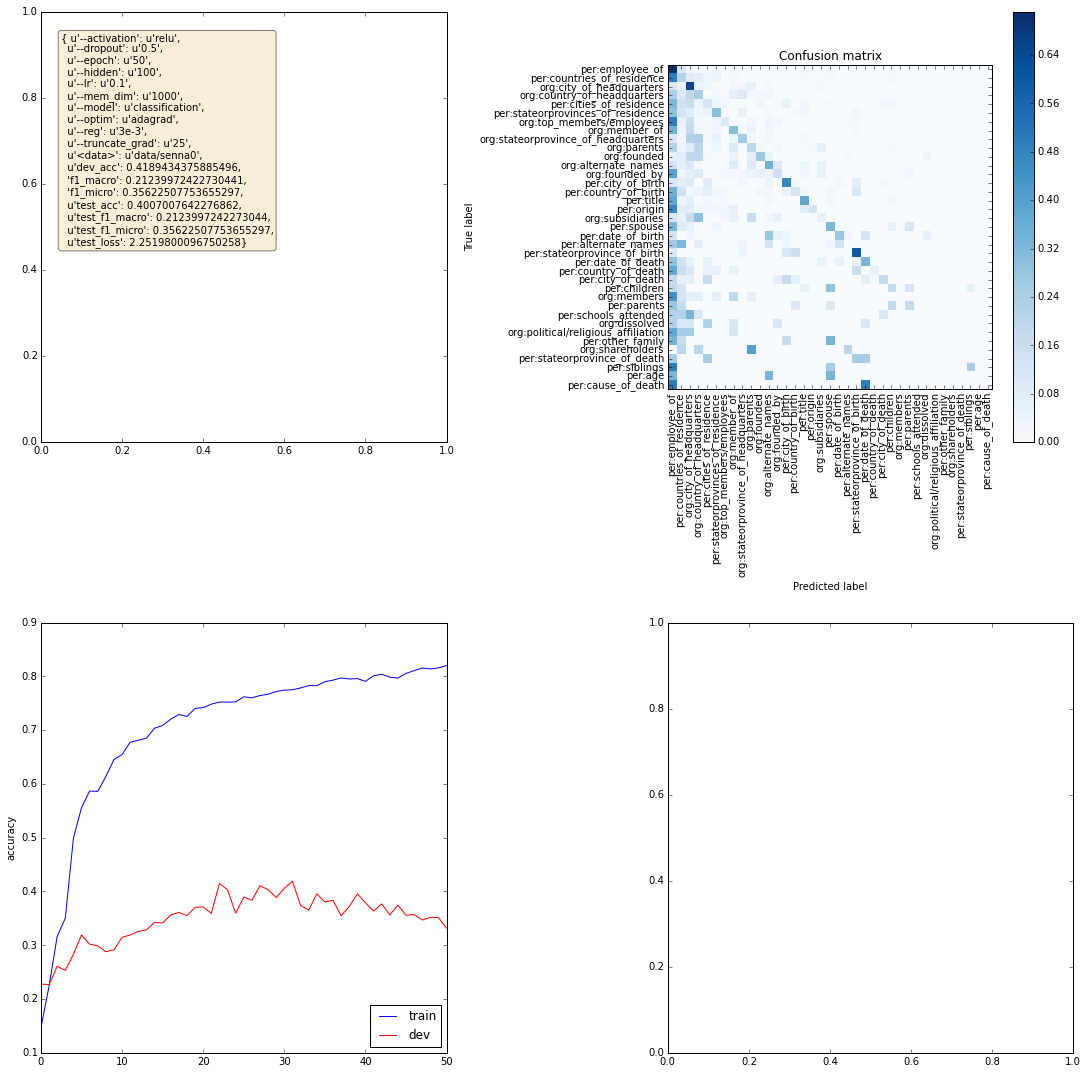

In [5]:
P.close('all')
print_experiment(classification_dir)

processed ./relu_0.5_50_30_0.1_1000_filter_adagrad_3e-3_100_data_senna0/


/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:931: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:931: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


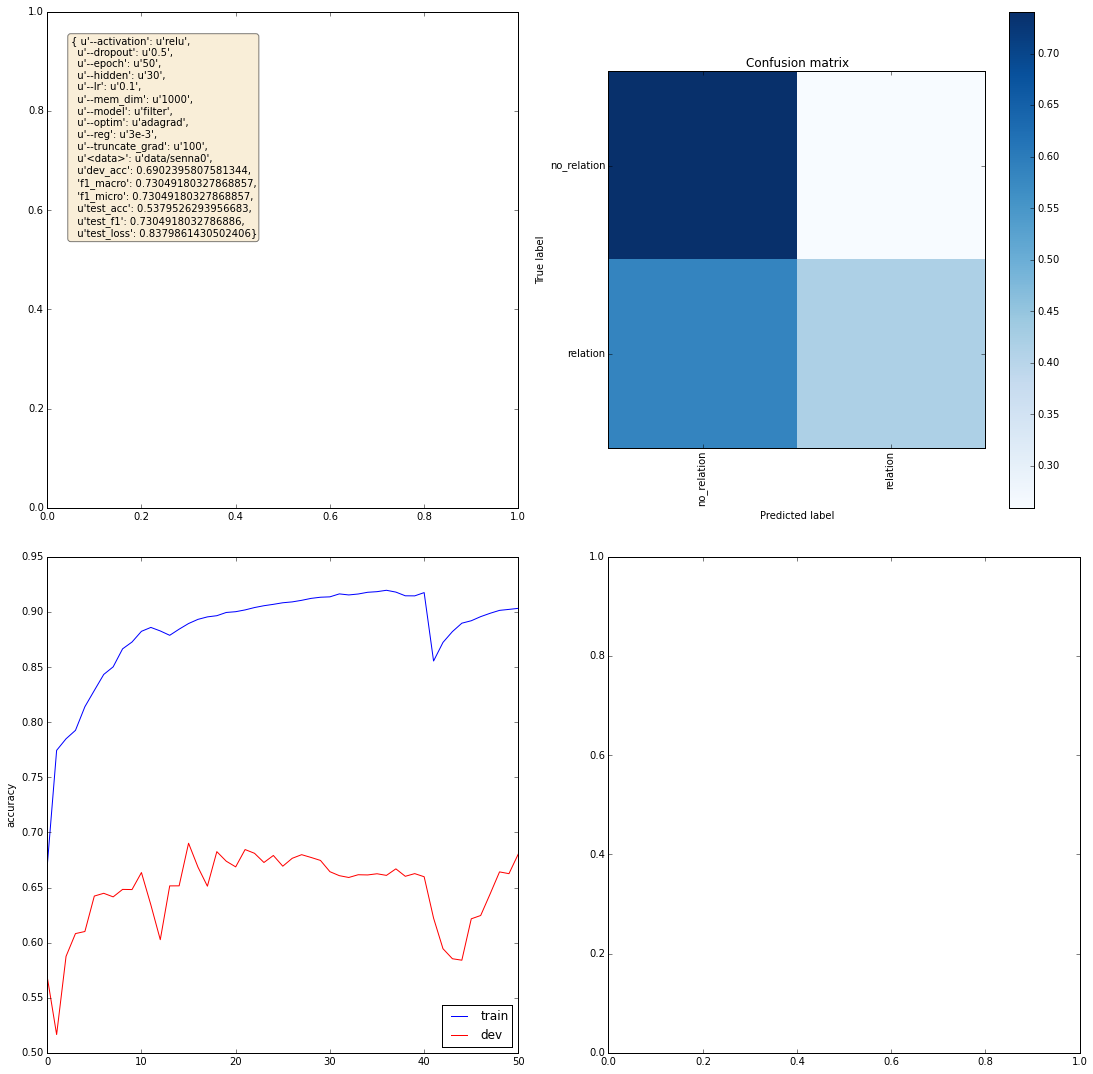

In [6]:
print_experiment(filter_dir)

In [7]:
def load_model(folder):
    with open(os.path.join(folder, 'model.pkl')) as f:
        return pkl.load(f)

filter_model = load_model(filter_dir)
classi_model = load_model(classification_dir)

Couldn't import dot_parser, loading of dot files will not be possible.


/usr/local/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


In [32]:
from train import one_hot
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from pprint import pprint

def evaluate(filter_threshold=0.5):
    preds = []
    targs = []
    for X, Y in d.generate_batches('test', label='raw'):
        Y_one_hot = one_hot(Y, len(d.rel_vocab))
        filter_pred = filter_model.predict(X, verbose=False).flatten() > filter_threshold
        pred = classi_model.predict_classes(X, verbose=False).flatten()
        unrelated = filter_pred == 0
        pred[unrelated] = d.rel_vocab['no_relation']
        preds.append(pred)
        targs.append(Y.flatten())
    preds = np.concatenate(preds)
    targs = np.concatenate(targs)
    f1, prec, rec = [f(targs, preds, average='micro') for f in [f1_score, precision_score, recall_score]]
    acc = accuracy_score(targs, preds)
    return {'f1':f1, 'precision':prec, 'recall':rec, 'accuracy':acc, 'preds':preds, 'targs':targs}

In [37]:
best = None
for threshold in [0.1, 0.3, 0.5, 0.7, 0.9]:
    print 'threshold', threshold
    result = evaluate(threshold)
    if best is None or result['f1'] > best['f1']:
        best = result
    pprint(result)
print 'best:'
pprint(best)

threshold 0.1
{'accuracy': 0.24866310160427807,
 'f1': 0.24866310160427807,
 'precision': 0.24866310160427807,
 'preds': array([ 9, 13,  0, ..., 22,  0, 15]),
 'recall': 0.24866310160427807,
 'targs': array([ 1, 13,  9, ..., 27,  1,  1])}
threshold 0.3
{'accuracy': 0.28520499108734404,
 'f1': 0.28520499108734404,
 'precision': 0.28520499108734404,
 'preds': array([ 1,  2, 10, ..., 10,  0, 15]),
 'recall': 0.28520499108734404,
 'targs': array([1, 2, 0, ..., 1, 1, 1])}
threshold 0.5
{'accuracy': 0.32174688057041001,
 'f1': 0.32174688057041001,
 'precision': 0.32174688057041001,
 'preds': array([ 1, 31,  1, ...,  0,  0,  1]),
 'recall': 0.32174688057041001,
 'targs': array([ 2, 10,  0, ...,  7,  1,  1])}
threshold 0.7
{'accuracy': 0.35531788472964942,
 'f1': 0.35531788472964942,
 'precision': 0.35531788472964942,
 'preds': array([ 1,  1,  1, ...,  1,  1, 26]),
 'recall': 0.35531788472964942,
 'targs': array([ 7,  1,  1, ...,  1, 37,  7])}
threshold 0.9
{'accuracy': 0.34997029114676176,
 '

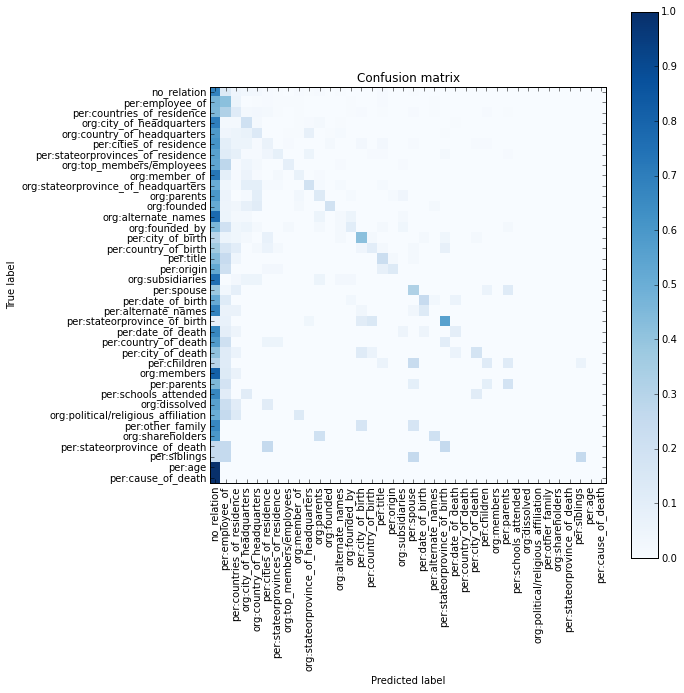

In [38]:
counts = Counter(best['targs'].tolist())
order = np.array([e[0] for e in counts.most_common()])
counts = np.array([e[1] for e in counts.most_common()])

cm = confusion_matrix(best['targs'], best['preds'], order)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = P.subplots(figsize=(10, 10))
plot_confusion_matrix(ax, cm, order, title='Confusion matrix', cmap=P.cm.Blues)